In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from tqdm import tqdm

torch.manual_seed(0) #set seed for reproducibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#data augmentation stuff
transforms = v2.Compose([
    v2.RandomRotation(360), #rotate image anywhere from 0-360 deg
    #v2.RandomResizedCrop(size=(28, 28), antialias=True),
    v2.ToTensor() #need to change img to tensor for batches to work
])

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

device

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


device(type='cuda')

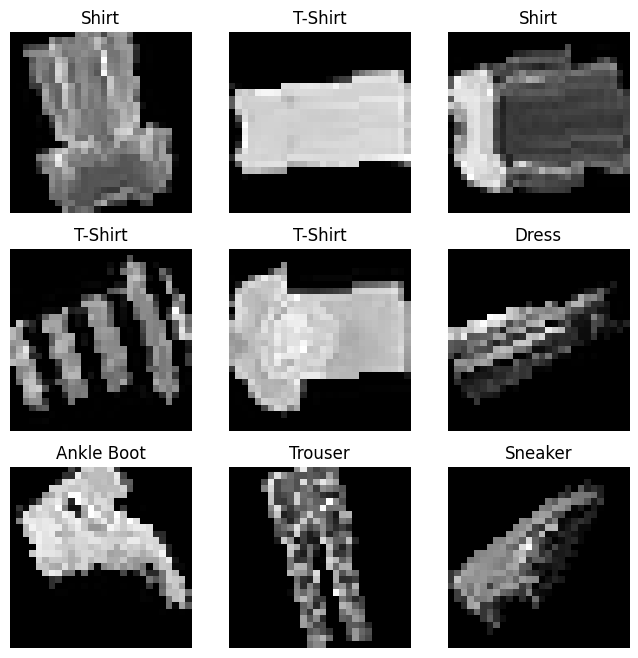

In [ ]:
#Take a sample of 9 entries from the training data and see what they look like after the rotation

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            # 2 hidden layers: 28*28 => 512 => 512 => 10
            nn.Linear(28*28, 512),
            nn.ReLU(), #activation function ReLU(x) = max(0, x)
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.ff = nn.Sequential(
            nn.Linear(216, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        # x = self.flatten(x) #reshape to vector
        # logits = self.linear_relu_stack(x) #run the model (forward propagation)
        # return logits
        x = self.relu(self.pool(self.conv1(x)))
        x = self.relu(self.pool(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = self.flatten(x)
        logits = self.ff(x)
        return logits

model = NeuralNetwork().to(device)

In [ ]:
learning_rate = 1e-4
batch_size = 64
epochs = 30

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [ ]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    return num_correct / num_samples

#train
model.train()
for epoch in range(epochs):
    epoch_loss = 0.0
    for batch_idx, (data, labels) in enumerate(tqdm(train_dataloader)):
        data = data.to(device)
        labels = labels.to(device)

        #forward
        preds = model(data)
        loss = loss_fn(preds, labels)

        #backward
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        #loss
        epoch_loss += loss.item()

    #TensorBoard to plot acc
    training_acc = check_accuracy(train_dataloader, model)
    print("Epoch: " + str(epoch+1) + " | acc: " + str(training_acc) + " | loss: " + str(epoch_loss))

    #writer.add_scalar("Loss/train", loss, epoch)
    #writer.add_scalar("Accuracy/", check_accuracy(train_dataloader, model)*100, epoch)

model.eval()
print(f"Accuracy on test set: {check_accuracy(test_dataloader, model)*100:.2f}")

#writer.flush()
#writer.close()

100%|██████████| 938/938 [00:17<00:00, 54.35it/s]


Epoch: 1 | acc: tensor(0.3792, device='cuda:0') | loss: 1743.648997783661


100%|██████████| 938/938 [00:16<00:00, 56.14it/s]


Epoch: 2 | acc: tensor(0.4925, device='cuda:0') | loss: 1395.9435110092163


100%|██████████| 938/938 [00:17<00:00, 53.76it/s]


Epoch: 3 | acc: tensor(0.5316, device='cuda:0') | loss: 1227.2508360147476


100%|██████████| 938/938 [00:16<00:00, 55.44it/s]


Epoch: 4 | acc: tensor(0.5516, device='cuda:0') | loss: 1131.2283423542976


100%|██████████| 938/938 [00:16<00:00, 55.95it/s]


Epoch: 5 | acc: tensor(0.5680, device='cuda:0') | loss: 1079.4211060404778


100%|██████████| 938/938 [00:17<00:00, 53.67it/s]


Epoch: 6 | acc: tensor(0.5785, device='cuda:0') | loss: 1044.158473789692


100%|██████████| 938/938 [00:16<00:00, 56.19it/s]


Epoch: 7 | acc: tensor(0.5890, device='cuda:0') | loss: 1016.9706683754921


100%|██████████| 938/938 [00:17<00:00, 53.54it/s]


Epoch: 8 | acc: tensor(0.5983, device='cuda:0') | loss: 992.423647403717


100%|██████████| 938/938 [00:17<00:00, 52.90it/s]


Epoch: 9 | acc: tensor(0.6099, device='cuda:0') | loss: 969.6599920392036


100%|██████████| 938/938 [00:16<00:00, 55.63it/s]


Epoch: 10 | acc: tensor(0.6207, device='cuda:0') | loss: 948.1735340356827


100%|██████████| 938/938 [00:17<00:00, 54.70it/s]


Epoch: 11 | acc: tensor(0.6285, device='cuda:0') | loss: 930.197717487812


100%|██████████| 938/938 [00:16<00:00, 56.59it/s]


Epoch: 12 | acc: tensor(0.6338, device='cuda:0') | loss: 913.9301299452782


100%|██████████| 938/938 [00:16<00:00, 57.51it/s]


Epoch: 13 | acc: tensor(0.6425, device='cuda:0') | loss: 899.5905843377113


100%|██████████| 938/938 [00:16<00:00, 56.79it/s]


Epoch: 14 | acc: tensor(0.6472, device='cuda:0') | loss: 886.7769531607628


100%|██████████| 938/938 [00:16<00:00, 58.39it/s]


Epoch: 15 | acc: tensor(0.6533, device='cuda:0') | loss: 876.3681764602661


100%|██████████| 938/938 [00:16<00:00, 57.67it/s]


Epoch: 16 | acc: tensor(0.6565, device='cuda:0') | loss: 863.6402668952942


100%|██████████| 938/938 [00:16<00:00, 56.66it/s]


Epoch: 17 | acc: tensor(0.6597, device='cuda:0') | loss: 856.4905059337616


100%|██████████| 938/938 [00:16<00:00, 57.80it/s]


Epoch: 18 | acc: tensor(0.6647, device='cuda:0') | loss: 848.0107046961784


100%|██████████| 938/938 [00:16<00:00, 56.29it/s]


Epoch: 19 | acc: tensor(0.6653, device='cuda:0') | loss: 839.3567944169044


100%|██████████| 938/938 [00:16<00:00, 57.83it/s]


Epoch: 20 | acc: tensor(0.6708, device='cuda:0') | loss: 832.9999570846558


100%|██████████| 938/938 [00:16<00:00, 58.57it/s]


Epoch: 21 | acc: tensor(0.6724, device='cuda:0') | loss: 824.1274435520172


100%|██████████| 938/938 [00:16<00:00, 56.85it/s]


Epoch: 22 | acc: tensor(0.6732, device='cuda:0') | loss: 815.9997469782829


100%|██████████| 938/938 [00:15<00:00, 58.74it/s]


Epoch: 23 | acc: tensor(0.6764, device='cuda:0') | loss: 810.7268983125687


100%|██████████| 938/938 [00:16<00:00, 56.89it/s]


Epoch: 24 | acc: tensor(0.6787, device='cuda:0') | loss: 807.3062573075294


100%|██████████| 938/938 [00:16<00:00, 58.37it/s]


Epoch: 25 | acc: tensor(0.6838, device='cuda:0') | loss: 798.898846924305


100%|██████████| 938/938 [00:16<00:00, 57.61it/s]


Epoch: 26 | acc: tensor(0.6856, device='cuda:0') | loss: 791.5903129577637


100%|██████████| 938/938 [00:16<00:00, 57.45it/s]


Epoch: 27 | acc: tensor(0.6871, device='cuda:0') | loss: 788.1626605987549


100%|██████████| 938/938 [00:16<00:00, 58.04it/s]


Epoch: 28 | acc: tensor(0.6877, device='cuda:0') | loss: 781.0928925573826


100%|██████████| 938/938 [00:16<00:00, 56.81it/s]


Epoch: 29 | acc: tensor(0.6891, device='cuda:0') | loss: 779.5050315856934


100%|██████████| 938/938 [00:16<00:00, 57.95it/s]


Epoch: 30 | acc: tensor(0.6904, device='cuda:0') | loss: 772.7138007283211
Accuracy on test set: 68.34
